# 1. Import and Data

In [74]:
import numpy as np
import pandas as pd 
import scipy.io as sio
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from mlxtend.data import loadlocal_mnist
from sklearn.preprocessing import OneHotEncoder

In [75]:
mat_content = sio.loadmat("binaryalphadigs.mat")

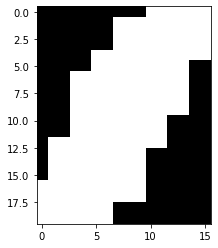

In [76]:
plt.imshow(mat_content['dat'][1][1], cmap='gray')

In [77]:
def lire_alpha_digit(dataset, list_idx):
    imgs_set = dataset[list_idx,:].flatten()
    imgs_flatten = []

    for img in imgs_set:
        imgs_flatten.append(img.flatten())

    imgs_set_output = np.array(imgs_flatten)

    return imgs_set_output

In [110]:
# We choose to generate the letter 'F'
list_idx = [15]
images =lire_alpha_digit(dataset=mat_content['dat'], list_idx=list_idx)

# 2. Restricted Boltzmann Machine (RBM) on Binary AlphaDigits

In [111]:
# Creation of functions sigmoid and softmax
def sigmoid(x):
    return 1 / (1 + np.exp(x))


def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1).reshape(-1, 1)

In [168]:
#Define the RBM class
class RBM():
    
    def __init__(self, p, q):
        # Set number of visible and hidden units
        self.p = p
        self.q = q
        # Initialize weights randomly with normal distribution
        self.W = np.random.normal(loc=0, scale=0.01, size=(p, q))
        # Initialize biases to zero
        self.a = np.zeros(p)
        self.b = np.zeros(q)
    
    # Function to compute the hidden probabilities and activations
    def entree_sortie_RBM(self, X, act='sigmoid'):
        # Compute the activations of the hidden layer
        proj = X @ self.W + self.b
        if act=='sigmoid':
        # Compute the probabilities of the hidden layer given the input
            p_h = sigmoid(-proj)
        else:
            p_h = softmax(-proj)
        # Sample from the probabilities to get the binary states of the hidden layer
        h = 1 * (np.random.rand(*p_h.shape) < p_h)
        return p_h, h

    # Function to compute the visible probabilities and activations
    def sortie_entree_RBM(self, Y):
        # Compute the activations of the visible layer
        proj = Y @ self.W.T + self.a
        # Compute the probabilities of the visible layer given the hidden layer
        p_v = sigmoid(-proj)
        # Sample from the probabilities to get the binary states of the visible layer
        v = 1 * (np.random.rand(*p_v.shape) < p_v)
        return p_v, v

    # Function to train the RBM
    def train_RBM(self, data, epochs=10000, learning_rate=0.01, batch_size=50, verbose=True):
        # Set number of samples in the dataset
        n_samples = data.shape[0]
        # Initialize the loss array
        loss = []

        # Loop over the number of epochs
        for epoch in range(1, epochs + 1):
            # Shuffle the data
            data2 = np.copy(data)
            np.random.shuffle(data2)

            # Loop over the batches
            for batch in range(0, n_samples, batch_size):
                # Get the indices of the current batch
                batch_indices = np.arange(batch, min(batch + batch_size, n_samples))
                # Get the current batch
                x = data2[batch_indices, :]
                # Set the initial visible activations to the input
                v0 = x
                # Compute the hidden probabilities and activations
                p_hv0, h0 = self.entree_sortie_RBM(v0)
                # Compute the visible probabilities and activations
                p_vh0, v1 = self.sortie_entree_RBM(h0)
                # Compute the hidden probabilities and activations again
                p_hv1, h1 = self.entree_sortie_RBM(v1)

                # Compute the gradient
                grad_a = np.mean(v0 - v1, axis=0)
                grad_b = np.mean(p_hv0 - p_hv1, axis=0)
                grad_W = v0.T @ p_hv0 - v1.T @ p_hv1

                # Update the weights and biases
                self.a += learning_rate * grad_a
                self.b += learning_rate * grad_b
                self.W += learning_rate * grad_W

            # Compute the loss on the training set
            output, _ = self.entree_sortie_RBM(data2)
            reconstructed_input, _ = self.sortie_entree_RBM(output)
            size = n_samples * self.p
            loss.append(np.sum((reconstructed_input - data2)**2) / size)
            if verbose:
                if not(epoch % 20) or epoch == 1:
                    print(f'Epoch {epoch} out of {epochs}, loss: {loss[-1]}')

        return self, loss

    def generer_image_RBM(self, n_imgs, n_iter, dataset='alphadigit'):
        fig = plt.figure()
        fig.patch.set_facecolor('black')
        if dataset == 'alphadigit':
            shape = (20, 16)
        elif dataset == 'mnist':
            shape = (28, 28)
        for i in range(n_imgs):
            v = 1 * (np.random.rand(self.p) < 0.5)
            v = v.reshape(1, v.shape[0])
            for j in range(n_iter):
                _, h = self.entree_sortie_RBM(v)
                _, v = self.sortie_entree_RBM(h)
            plt.subplot(n_imgs // 5, 5, i + 1)
            plt.imshow(v.reshape(shape), cmap='gray')
            plt.axis('off')
        plt.show()


Epoch 1 out of 500, loss: 0.19207928254650222
Epoch 20 out of 500, loss: 0.08075209803433016
Epoch 40 out of 500, loss: 0.04035792444769147
Epoch 60 out of 500, loss: 0.01905594745984566
Epoch 80 out of 500, loss: 0.009434800004863459
Epoch 100 out of 500, loss: 0.005075002477346229
Epoch 120 out of 500, loss: 0.003278164169813015
Epoch 140 out of 500, loss: 0.0022567273841012122
Epoch 160 out of 500, loss: 0.001546449375054348
Epoch 180 out of 500, loss: 0.0011361031364794207
Epoch 200 out of 500, loss: 0.0009079390591412085
Epoch 220 out of 500, loss: 0.0007056713384178644
Epoch 240 out of 500, loss: 0.000592155017019636
Epoch 260 out of 500, loss: 0.0004964175728422244
Epoch 280 out of 500, loss: 0.00041879502921559134
Epoch 300 out of 500, loss: 0.0003605197226348184
Epoch 320 out of 500, loss: 0.00029203017255967156
Epoch 340 out of 500, loss: 0.00026685105845827525
Epoch 360 out of 500, loss: 0.00022869873206280927
Epoch 380 out of 500, loss: 0.0001982742301649307
Epoch 400 out o

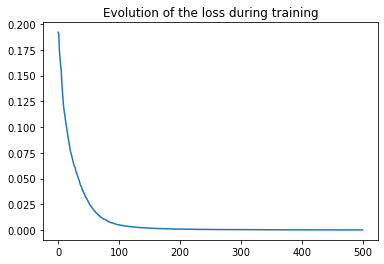

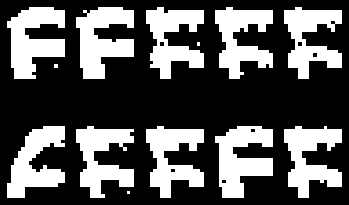

In [96]:
#Set the number of visible units and number of hidden units
p = 20*16
q = 250

#Initialize a RBM object with p visible units and q hidden units
rbm = RBM(p, q)

#Set the hyperparameters for training the RBM
epochs = 500
learning_rate = 0.01
batch_size = 10

#Train the RBM on a dataset of images and get the trained RBM and the loss
RBM_trained, loss = rbm.train_RBM(images, epochs, learning_rate, batch_size)

#Plot the evolution of the loss during training
plt.plot(loss)
plt.title("Evolution of the loss during training")
plt.show()

#Generate new images from the trained RBM and display them
n_iter = 1000
n_imgs = 10
RBM_trained.generer_image_RBM(n_imgs, n_iter)

# 3. Deep Belief Network (DBN) on Binary AlphaDigits

In [8]:
#Define the DBN class
class DBN():
    # Initialize the number of neurons in each layer of the DBN with a list of integers
    def __init__(self, neurons):
        self.RBMs_list = []
        for i in range(len(neurons) - 1):
            self.RBMs_list.append(RBM(neurons[i], neurons[i+1]))

    def pretrain_DBN(self, data, n_epoch=10000, lr_rate=0.01, batch_size=50, verbose = True):
        losses = []
        for rbm in self.RBMs_list:
            rbm, loss = rbm.train_RBM(data, n_epoch, lr_rate, batch_size, verbose = verbose)
            _, data = rbm.entree_sortie_RBM(data)
            losses.append(loss)
        return self, losses

    def generer_image_DBN(self, n_imgs, n_iter, dataset='alphadigit'):
        fig = plt.figure()
        fig.patch.set_facecolor('black')
        if dataset == 'alphadigit':
            shape = (20, 16)
        elif dataset == 'mnist':
            shape = (28, 28)
        for i in range(n_imgs):
            data = 1 * (np.random.rand(self.RBMs_list[0].p) < 0.5)
            data = data.reshape(1, data.shape[0])
            for itr in range(n_iter):
                for rbm in self.RBMs_list:
                    _, data = rbm.entree_sortie_RBM(data)
                for rbm in reversed(self.RBMs_list):
                    _, data = rbm.sortie_entree_RBM(data)
            plt.subplot(n_imgs // 5, 5, i + 1)
            plt.imshow(data.reshape(shape), cmap='gray')
            plt.axis('off')
        plt.show()

Epoch 1 out of 2000, loss: 0.19250909570327815
Epoch 20 out of 2000, loss: 0.16904519987533168
Epoch 40 out of 2000, loss: 0.14566101855218158
Epoch 60 out of 2000, loss: 0.11586919741867115
Epoch 80 out of 2000, loss: 0.10728526945552386
Epoch 100 out of 2000, loss: 0.09891518150072905
Epoch 120 out of 2000, loss: 0.09027717678903521
Epoch 140 out of 2000, loss: 0.08310476506159778
Epoch 160 out of 2000, loss: 0.07665494079532542
Epoch 180 out of 2000, loss: 0.0709757450694182
Epoch 200 out of 2000, loss: 0.06584530165140833
Epoch 220 out of 2000, loss: 0.06146043824634364
Epoch 240 out of 2000, loss: 0.05659238626910377
Epoch 260 out of 2000, loss: 0.05243323561765123
Epoch 280 out of 2000, loss: 0.04823119204286455
Epoch 300 out of 2000, loss: 0.0445318511188874
Epoch 320 out of 2000, loss: 0.04084801100489839
Epoch 340 out of 2000, loss: 0.03749273886442248
Epoch 360 out of 2000, loss: 0.034110554335821955
Epoch 380 out of 2000, loss: 0.031171470241088222
Epoch 400 out of 2000, los

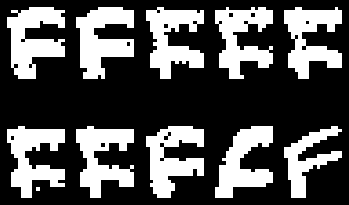

In [138]:
neurons = [images[0, :].shape[0], 200, 150, 100] #taille du réseau
dbn = DBN(neurons)
dbn, losses = dbn.pretrain_DBN(images, n_epoch=2000, lr_rate=0.001)
generated = dbn.generer_image_DBN(n_imgs, n_iter=n_iter)

# 4. Deep Neural Network (DNN) on MNIST

In [112]:
def read_mnist():
    X_train, y_train = loadlocal_mnist(images_path='train-images-idx3-ubyte',
                         labels_path='train-labels-idx1-ubyte')
    X_test, y_test = loadlocal_mnist(images_path='t10k-images-idx3-ubyte',
                         labels_path='t10k-labels-idx1-ubyte')
    #We binarize the images
    X_train = np.where(X_train > 126, 1, 0)
    X_test = np.where(X_test > 126, 1, 0)
    #We encode targets
    oh = OneHotEncoder()
    y_train = oh.fit_transform(y_train.reshape(-1,1)).toarray()
    y_test = oh.fit_transform(y_test.reshape(-1,1)).toarray()
    
    return X_train, X_test, y_train, y_test

In [113]:
X_train, X_test, y_train, y_test = read_mnist()

In [118]:
# Values of hyperparameters
vect_DNN = [784, 100, 50, 10] #DNN network size
n_iter_RBM = 100
n_iter_DBN = 200
lr = 0.01
batch_size = 32

In [119]:
def cross_entropy(y_hat, y):
    loss = []
    for k in range(y.shape[0]):
        loss.append(np.sum([-y[k,j]*np.log(y_hat[k,j]) for j in range(y.shape[1])]))
    return loss

In [93]:
#Define the class DNN, which inherits from DBN
class DNN(DBN):
    
    # It calls the constructor of the parent class, DBN, passing the neurons parameter
    def __init__(self, neurons):
        super().__init__(neurons)
        
    # Calculates the softmax function of the output of a given RBM and a given data
    def calcul_softmax(self, rbm, data):
        p_h, _ = rbm.entree_sortie_RBM(data, act='softmax')
        return p_h
    
    # Computes the output of the network given an input data
    def entree_sortie_reseau(self, data):
        outputs = [data]
        # For each RBM of the network except the last one, compute the output and append it to the outputs list
        for rbm in self.RBMs_list[:-1]:
            probas, _ = rbm.entree_sortie_RBM(outputs[-1])
            outputs.append(probas)
        # Compute the softmax function of the output of the last RBM and append it to the outputs list
        outputs.append(self.calcul_softmax(self.RBMs_list[-1], outputs[-1]))
        return outputs
    
    # Performs backpropagation algorithm to optimize weights and biases of the network
    def retropropagation(self, data, labels, batch_size=50, epochs=10000, lr_rate=0.01, verbose = True):
        n_samples = data.shape[0]
        loss = []
        
        for i in range(1, epochs + 1):
            loss_batches = []
            # The data is split into batches and for each batch
            for z in range(0, n_samples, batch_size):
                batch = data[z:min(n_samples, z + batch_size), :]
                batch_labels = labels[z:min(n_samples, z + batch_size), :]
                # The output of the network is computed for the current batch
                outputs = self.entree_sortie_reseau(batch)
                # The error is computed as the difference between the predicted and actual output
                last_layer = self.RBMs_list[-1]
                # The weights and biases of the output layer are updated based on the error
                c = (outputs[-1] - batch_labels)
                last_layer.W -= lr_rate * outputs[-2].T @ c / batch_size
                last_layer.b -= lr_rate * np.mean(c, axis = 0) / batch_size
                for idx, rbm in reversed(list(enumerate(self.RBMs_list[:-1]))):
                    # The error is backpropagated through the layer
                    c = c@self.RBMs_list[idx+1].W.T * outputs[idx+1] * (1-outputs[idx+1])
                    # The weights and biases of the layer are updated based on the error
                    rbm.W -= lr_rate / batch_size * outputs[idx].T @ c 
                    rbm.b -= lr_rate * np.mean(c, axis=0) 
                # The loss for the batch is computed and saved
                loss_batches += cross_entropy(outputs[-1], batch_labels)
            # The average loss for the epoch is computed and saved
            loss.append(np.mean(loss_batches))
            if verbose:
                if not(i % 25) or i == 1:
                    print(f"Epoch {i} out of {epochs}. CELoss value is {loss[-1]}")
        return self, loss

    def test_dnn(self, data, labels, verbose = True):
        for rbm in self.RBMs_list[:-1]:
            _, data = rbm.entree_sortie_RBM(data)
        preds = np.argmax(self.calcul_softmax(self.RBMs_list[-1], data),
                          axis=1)
        good_labels = 0
        #print(preds)
        for idx, pred in enumerate(preds):
            if pred == np.argmax(labels[idx]):
                good_labels += 1
        if verbose:
            print("The percentage of false labeled data is ",
              100*(labels.shape[0] - good_labels) / labels.shape[0])
        return 100*(labels.shape[0] - good_labels) / labels.shape[0]
    
    def get_pred(self, data):
        for rbm in self.RBMs_list[:-1]:
            _, data = rbm.entree_sortie_RBM(data)
        probs = self.calcul_softmax(self.RBMs_list[-1], data)
        return(probs)

Epoch 1 out of 100, loss: 0.030189863985491682
Epoch 20 out of 100, loss: 0.02891482998204111
Epoch 40 out of 100, loss: 0.029296238529759443
Epoch 60 out of 100, loss: 0.029116836386344578
Epoch 80 out of 100, loss: 0.028820869308083905
Epoch 100 out of 100, loss: 0.02850189369956272
Epoch 1 out of 100, loss: 0.03534394982145237
Epoch 20 out of 100, loss: 0.023983848040750756
Epoch 40 out of 100, loss: 0.022983769920452556
Epoch 60 out of 100, loss: 0.022552557707830823
Epoch 80 out of 100, loss: 0.022270300475722
Epoch 100 out of 100, loss: 0.022017105677102994
Epoch 1 out of 100, loss: 0.10931966439085888
Epoch 20 out of 100, loss: 0.10460172854072539
Epoch 40 out of 100, loss: 0.10432417329072646
Epoch 60 out of 100, loss: 0.10431404722866916
Epoch 80 out of 100, loss: 0.10431328634093658
Epoch 100 out of 100, loss: 0.1043478667766514
Epoch 1 out of 200. CELoss value is 6.101868421164524
Epoch 25 out of 200. CELoss value is 0.40811134551440226
Epoch 50 out of 200. CELoss value is 0

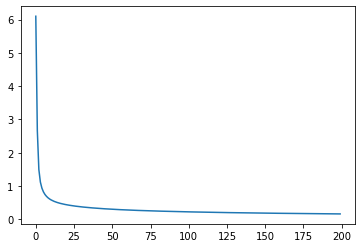

The percentage of false labeled data is  9.23


9.23

In [145]:
dnn = DNN(vect_DNN) #Initialization of the DNN

#We train the DNN in an unsupervised way
dnn, losses = dnn.pretrain_DBN(X_train, batch_size = batch_size, n_epoch = n_iter_RBM)

#Then we train the DNN in an supervised way
dnn, loss = dnn.retropropagation(data = X_train, labels = y_train, epochs = n_iter_DBN,
                                 batch_size = batch_size, lr_rate = lr)
plt.plot(loss)
plt.show()

dnn.test_dnn(X_test, y_test)

(<matplotlib.image.AxesImage at 0x7fc1c5921ee0>,
 array([8.51949376e-03, 1.56525497e-07, 5.17126218e-05, 9.26509808e-04,
        5.02245843e-07, 9.02434044e-05, 5.76317969e-07, 9.99668850e-01,
        2.27362531e-07, 1.29810627e-03]))

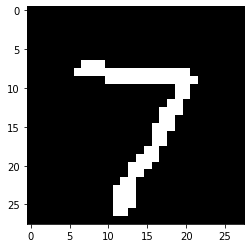

In [147]:
i=0
plt.imshow(X_test[i].reshape(28,28),cmap='gray'),probs[i]

# 5. Analysis

## 5.1 Number of layers

In [150]:
grid = [[784, 10], [784, 200, 10], [784, 200, 200, 10], [784, 200, 200, 200, 10], [784, 200, 200, 200, 200, 10]]
list_train = []
list_pretrain = []
for vect in tqdm(grid):
    print(vect)
    dnn1 = DNN(vect)
    dnn2 = DNN(vect) # We initialize two identical networks
    
    #We train one DNN in an unsupervised way
    dnn1, losses = dnn1.pretrain_DBN(X_train, batch_size = batch_size, n_epoch = n_iter_RBM, verbose = False) 
    #Then we train it in an supervised way
    dnn1, loss = dnn1.retropropagation(data = X_train, labels = y_train, epochs = n_iter_DBN,
                                 batch_size = batch_size, lr_rate = lr, verbose = False)
    #We train the second one only in a supervised way
    dnn2, loss = dnn2.retropropagation(data = X_train, labels = y_train, epochs = n_iter_DBN,
                                 batch_size = batch_size, lr_rate = lr, verbose = False)
    list_train.append(dnn2.test_dnn(X_test, y_test, verbose = False))
    list_pretrain.append(dnn1.test_dnn(X_test, y_test, verbose = False))

  0%|          | 0/5 [00:00<?, ?it/s]

[784, 10]


/var/folders/f0/q7nn178n5cldx0lvl6yvbbn40000gn/T/ipykernel_39610/2300698629.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
 20%|██        | 1/5 [26:30<1:46:03, 1590.81s/it]

[784, 200, 10]


 40%|████      | 2/5 [1:10:08<1:49:44, 2194.84s/it]

[784, 200, 200, 10]


 60%|██████    | 3/5 [2:03:59<1:28:56, 2668.19s/it]

[784, 200, 200, 200, 10]


 80%|████████  | 4/5 [3:09:03<52:35, 3155.79s/it]  

[784, 200, 200, 200, 200, 10]


100%|██████████| 5/5 [4:24:12<00:00, 3170.51s/it]


In [158]:
dnn2.test_dnn(X_test, y_test, verbose = True)

The percentage of false labeled data is  90.41


90.41

In [153]:
list_pretrain

[10.06, 5.65, 6.96, 7.23, 10.66]

In [154]:
list_train

[8.7, 8.29, 16.09, 90.43, 90.42]

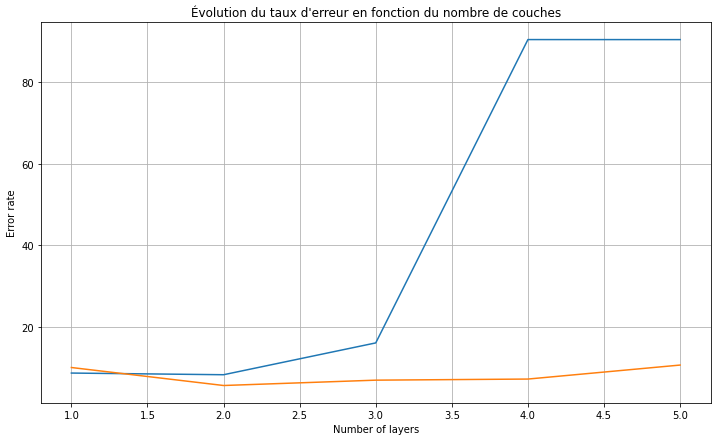

In [159]:
plt.figure(figsize=(12,7))
plt.title("Evolution du taux d'erreur en fonction du nombre de couches")
plt.xlabel('Number of layers')
plt.ylabel("Error rate")
plt.plot([1, 2, 3, 4, 5],list_train, label = 'réseau non preentrainé')
plt.plot([1, 2, 3, 4, 5],list_pretrain, label = 'réseau preentrainé')
plt.grid()
plt.show()

## 5.2 Number of neurons by layer

In [161]:
grid = [[784, 50, 50, 10], [784, 100, 100, 10],[784, 300, 300, 10], [784, 500, 500, 10], [784, 700, 700, 10]]
list_train = []
list_pretrain = []
for vect in tqdm(grid):
    print(vect)
    dnn1 = DNN(vect)
    dnn2 = DNN(vect) # We initialize two identical networks
   
    #We train one DNN in an unsupervised way
    dnn1, losses = dnn1.pretrain_DBN(X_train, batch_size = batch_size, n_epoch = n_iter_RBM, verbose = False) 
    #Then we train it in an supervised way
    dnn1, loss = dnn1.retropropagation(data = X_train, labels = y_train, epochs = n_iter_DBN,
                                 batch_size = batch_size, lr_rate = lr, verbose = False)
    #We train the second one only in a supervised way
    dnn2, loss = dnn2.retropropagation(data = X_train, labels = y_train, epochs = n_iter_DBN,
                                 batch_size = batch_size, lr_rate = lr, verbose = False)
    list_train.append(dnn2.test_dnn(X_test, y_test, verbose = False))
    list_pretrain.append(dnn1.test_dnn(X_test, y_test, verbose = False))
    print(list_train, list_pretrain)

  0%|          | 0/5 [00:00<?, ?it/s]

[784, 50, 50, 10]


 20%|██        | 1/5 [34:26<2:17:46, 2066.59s/it]

[20.68] [16.4]
[784, 100, 100, 10]


 40%|████      | 2/5 [1:13:28<1:51:25, 2228.52s/it]

[20.68, 17.98] [16.4, 9.66]
[784, 300, 300, 10]


 60%|██████    | 3/5 [2:29:59<1:50:14, 3307.14s/it]

[20.68, 17.98, 16.55] [16.4, 9.66, 7.32]
[784, 500, 500, 10]


 80%|████████  | 4/5 [4:34:04<1:22:20, 4940.93s/it]

[20.68, 17.98, 16.55, 15.41] [16.4, 9.66, 7.32, 7.38]
[784, 700, 700, 10]


100%|██████████| 5/5 [7:44:07<00:00, 5569.53s/it]  

[20.68, 17.98, 16.55, 15.41, 14.84] [16.4, 9.66, 7.32, 7.38, 7.72]


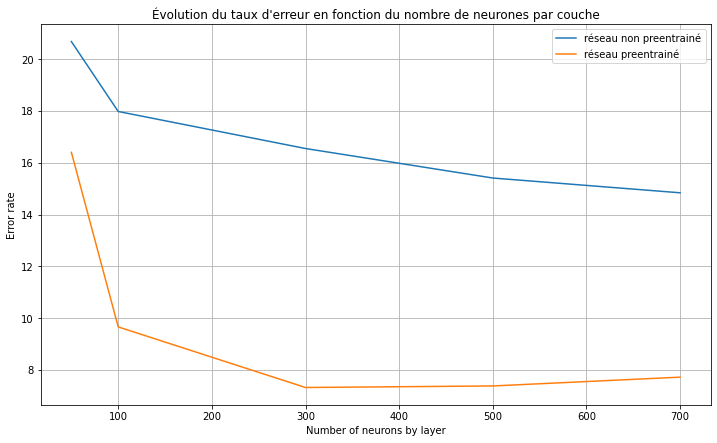

In [163]:
plt.figure(figsize=(12,7))
plt.title("Évolution du taux d'erreur en fonction du nombre de neurones par couche")
plt.xlabel('Number of neurons by layer')
plt.ylabel("Error rate")
plt.plot([50, 100, 300, 500, 700], list_train, label = 'réseau non preentrainé')
plt.plot([50, 100, 300, 500, 700], list_pretrain, label = 'réseau preentrainé')
plt.legend()
plt.grid()
plt.show()

## 5.3 Number of data trained

In [165]:
grid = [1000, 3000, 7000, 10000, 30000, 60000]
vect = [784, 50, 50, 10]
list_train = []
list_pretrain = []
for limit in tqdm(grid):
    #We split  our data
    X_train_ex = X_train[:limit]
    y_train_ex = y_train[:limit]

    dnn1 = DNN(vect)
    dnn2 = DNN(vect) # We initialize two identical networks
    
    #We train one DNN in an unsupervised way
    dnn1, losses = dnn1.pretrain_DBN(X_train_ex, batch_size = batch_size, n_epoch = n_iter_RBM, verbose = False) 

    #Then we train it in an supervised way
    dnn1, loss = dnn1.retropropagation(data = X_train_ex, labels = y_train_ex, epochs = n_iter_DBN,
                                 batch_size = batch_size, lr_rate = lr, verbose = False)
    
    #We train the second one only in a supervised way
    dnn2, loss = dnn2.retropropagation(data = X_train_ex, labels = y_train_ex, epochs = n_iter_DBN,
                                 batch_size = batch_size, lr_rate = lr, verbose = False)
    list_train.append(dnn2.test_dnn(X_test, y_test, verbose = False))
    list_pretrain.append(dnn1.test_dnn(X_test, y_test, verbose = False))

100%|██████████| 6/6 [1:12:39<00:00, 726.54s/it] 


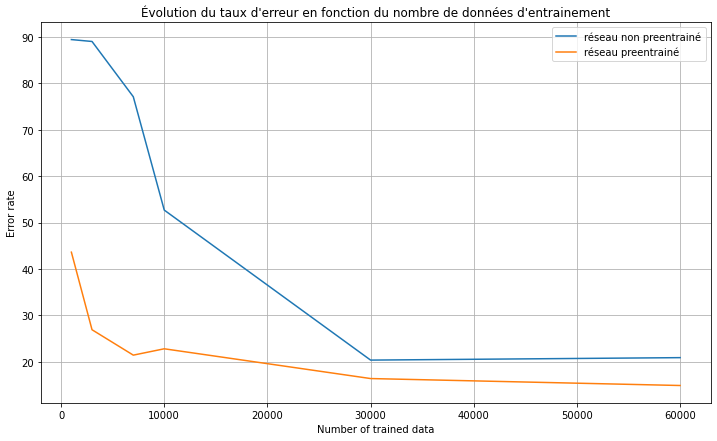

In [167]:
plt.figure(figsize=(12,7))
plt.title("Évolution du taux d'erreur en fonction du nombre de données d'entrainement")
plt.xlabel("Number of trained data")
plt.ylabel("Error rate")
plt.plot( [1000, 3000, 7000, 10000, 30000, 60000], list_train, label = 'réseau non preentrainé')
plt.plot([1000, 3000, 7000, 10000, 30000, 60000], list_pretrain, label = 'réseau preentrainé')
plt.grid()
plt.legend()
plt.show()

**=> As we can see on these 3 plots, the best model is maybe a pre trained network trained with 30 000 data, 300 neurons by layer and 2 layers.**

# 6. Variational Auto Encoder (VAE)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import pdb
import numpy as np
import matplotlib.pyplot as plt

def pytorch_to_numpy(x):
  return x.detach().numpy()

/Users/pierreloviton/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pierreloviton/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <AFB7C78A-1D52-38B1-9D33-93A75FA7D528> /Users/pierreloviton/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <9D4C7FD2-49A8-383A-AC3E-A560DE81B0D8> /Users/pierreloviton/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [31]:
from torch.utils.data import TensorDataset, DataLoader

TensorDataset()

def array_to_dataloader(X):
    tensor_x = torch.Tensor(X)
    my_dataset = TensorDataset(tensor_x) 
    my_dataloader = DataLoader(my_dataset)
    return my_dataloader

In [16]:
class VAE(torch.nn.Module ):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim,n_rows,n_cols,n_channels):
        super(VAE, self).__init__()

        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_channels = n_channels
        self.n_pixels = (self.n_rows)*(self.n_cols)
        self.z_dim = z_dim

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1) #FILL IN STUDENT
        self.fc2 = nn.Linear(h_dim1, h_dim2) #FILL IN STUDENT
        self.fc31 = nn.Linear(h_dim2, z_dim) #FILL IN STUDENT
        self.fc32 = nn.Linear(h_dim2, z_dim) #FILL IN STUDENT
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2) #FILL IN STUDENT
        self.fc5 = nn.Linear(h_dim2, h_dim1) #FILL IN STUDENT
        self.fc6 = nn.Linear(h_dim1, x_dim) #FILL IN STUDENT
    

    def encoder(self, x):
        h = F.relu(self.fc1(x.view(-1, self.n_pixels))) #FILL IN STUDENT
        h = F.relu(self.fc2((h))) #FILL IN STUDENT
        return F.relu(self.fc31(h)), F.relu(self.fc32(h)) #FILL IN STUDENT (remember, there are two outputs)
                   
    def decoder(self, z):
        h = F.relu(self.fc4(z)) #FILL IN STUDENT
        h = F.relu(self.fc5(h)) #FILL IN STUDENT
        return F.sigmoid(self.fc6(h)).view(-1,n_channels, n_rows,n_cols) #FILL IN STUDENT

    def sampling(self, mu, log_var):
        # this function samples a Gaussian distribution, with average (mu) and standard deviation specified (using log_var)
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def forward(self, x):
        z_mu, z_log_var = self.encoder(x) #FILL IN STUDENT
        z = self.sampling(z_mu, z_log_var) #FILL IN STUDENT
        return self.decoder(z), z_mu, z_log_var

    def loss_function(self,x, y, mu, log_var):
        reconstruction_error = F.binary_cross_entropy(y.view(-1, self.n_pixels), x.view(-1, self.n_pixels), reduction='sum')

        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        return reconstruction_error + KLD

In [47]:
# autoencoder parameters
n_rows = int(np.sqrt(X_train.shape[1]))
n_cols = int(np.sqrt(X_train.shape[1]))
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)
z_dim = 10 # number of labels here but you can change this as you wish
n_epochs = 50

In [18]:
# create model
vae_dim_1 = 512
vae_dim_2 = 256
vae_model = VAE(x_dim=n_pixels, h_dim1= vae_dim_1, h_dim2=vae_dim_2, z_dim=z_dim,n_rows=n_rows,n_cols=n_cols,n_channels=n_channels)
vae_optimizer = optim.Adam(vae_model.parameters())

In [20]:
print(vae_model)

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=10, bias=True)
  (fc32): Linear(in_features=256, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)


In [45]:
def train_vae(vae_model,data_train_loader, vae_optimizer, epoch, verbose=True):
    train_loss = 0
    for batch_idx, data in tqdm(enumerate(data_train_loader)):
        data = data[0]
        vae_optimizer.zero_grad()
        y, z_mu, z_log_var = vae_model(data) #FILL IN STUDENT
        loss_vae = vae_model.loss_function(data, y, z_mu, z_log_var) #FILL IN STUDENT
        loss_vae.backward()
        train_loss += loss_vae.item()
        vae_optimizer.step() 
        
        if verbose:
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_train_loader.dataset),
                100. * batch_idx / len(data_train_loader), loss_vae.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(data_train_loader.dataset)))


In [43]:
train_loader = array_to_dataloader(X_train[:10000])

In [48]:
# train the model
for epoch in range(0, n_epochs):
    train_vae(vae_model,train_loader, vae_optimizer, epoch, verbose=False)

10000it [03:25, 48.77it/s]


====> Epoch: 0 Average loss: 165.3170


10000it [03:12, 51.96it/s]


====> Epoch: 1 Average loss: 164.7732


10000it [03:14, 51.53it/s]


====> Epoch: 2 Average loss: 164.3487


10000it [03:25, 48.76it/s]


====> Epoch: 3 Average loss: 164.3182


10000it [03:34, 46.59it/s]


====> Epoch: 4 Average loss: 163.8695


10000it [03:36, 46.16it/s]


====> Epoch: 5 Average loss: 163.4868


10000it [03:35, 46.36it/s]


====> Epoch: 6 Average loss: 163.5350


10000it [03:31, 47.28it/s]


====> Epoch: 7 Average loss: 163.2339


10000it [03:27, 48.14it/s]


====> Epoch: 8 Average loss: 163.4739


10000it [03:41, 45.20it/s]


====> Epoch: 9 Average loss: 162.8703


10000it [03:40, 45.30it/s]


====> Epoch: 10 Average loss: 162.5159


10000it [03:56, 42.33it/s]


====> Epoch: 11 Average loss: 162.2970


10000it [03:33, 46.80it/s]


====> Epoch: 12 Average loss: 162.1294


10000it [03:25, 48.58it/s]


====> Epoch: 13 Average loss: 162.1147


10000it [04:11, 39.78it/s]


====> Epoch: 14 Average loss: 161.7298


10000it [03:33, 46.93it/s]


====> Epoch: 15 Average loss: 161.5175


10000it [03:24, 48.95it/s]


====> Epoch: 16 Average loss: 161.9331


10000it [03:23, 49.03it/s]


====> Epoch: 17 Average loss: 161.8086


10000it [03:20, 49.76it/s]


====> Epoch: 18 Average loss: 161.4683


10000it [03:18, 50.37it/s]


====> Epoch: 19 Average loss: 161.7101


10000it [03:19, 50.08it/s]


====> Epoch: 20 Average loss: 161.6035


10000it [03:21, 49.61it/s]


====> Epoch: 21 Average loss: 161.6603


10000it [03:27, 48.13it/s]


====> Epoch: 22 Average loss: 161.9992


10000it [04:09, 40.04it/s]


====> Epoch: 23 Average loss: 161.5895


10000it [03:54, 42.65it/s]


====> Epoch: 24 Average loss: 161.4706


10000it [03:30, 47.41it/s]


====> Epoch: 25 Average loss: 161.4049


10000it [03:33, 46.81it/s]


====> Epoch: 26 Average loss: 161.4705


10000it [03:26, 48.33it/s]


====> Epoch: 27 Average loss: 161.4768


10000it [03:22, 49.46it/s]


====> Epoch: 28 Average loss: 161.7420


10000it [03:18, 50.34it/s]


====> Epoch: 29 Average loss: 161.5257


10000it [03:18, 50.41it/s]


====> Epoch: 30 Average loss: 162.0129


10000it [03:19, 50.19it/s]


====> Epoch: 31 Average loss: 161.9546


10000it [03:21, 49.68it/s]


====> Epoch: 32 Average loss: 161.7272


10000it [03:16, 50.93it/s]


====> Epoch: 33 Average loss: 161.4751


10000it [03:17, 50.58it/s]


====> Epoch: 34 Average loss: 161.6779


10000it [03:23, 49.08it/s]


====> Epoch: 35 Average loss: 161.8816


10000it [03:30, 47.55it/s]


====> Epoch: 36 Average loss: 161.6291


10000it [03:25, 48.69it/s]


====> Epoch: 37 Average loss: 161.7402


10000it [03:32, 47.13it/s]


====> Epoch: 38 Average loss: 162.0344


10000it [03:22, 49.39it/s]


====> Epoch: 39 Average loss: 161.9783


10000it [03:36, 46.17it/s]


====> Epoch: 40 Average loss: 161.7459


10000it [03:19, 50.23it/s]


====> Epoch: 41 Average loss: 161.7540


10000it [03:18, 50.30it/s]


====> Epoch: 42 Average loss: 161.8520


10000it [03:20, 49.85it/s]


====> Epoch: 43 Average loss: 161.6945


10000it [03:18, 50.39it/s]


====> Epoch: 44 Average loss: 161.8865


10000it [03:21, 49.69it/s]


====> Epoch: 45 Average loss: 161.8767


10000it [03:20, 49.99it/s]


====> Epoch: 46 Average loss: 162.1042


10000it [03:19, 50.12it/s]


====> Epoch: 47 Average loss: 162.4790


10000it [03:21, 49.64it/s]


====> Epoch: 48 Average loss: 162.4296


10000it [03:36, 46.27it/s]


====> Epoch: 49 Average loss: 162.4674


In [41]:
def test(vae, test_loader):
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

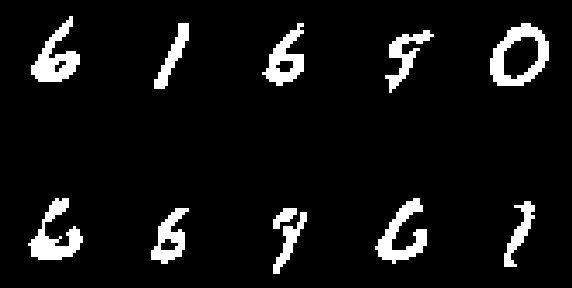

In [50]:
n_imgs = 10

fig, ax = plt.subplots(2, 5, figsize=(10, 6))
fig.patch.set_facecolor('black')
ax = ax.ravel()
with torch.no_grad():
    if torch.cuda.is_available():
        z = torch.randn(n_imgs, 2).cuda()
        sample = vae.decoder(z).cuda()
    else:
        z = torch.randn(n_imgs, 2)
        sample = vae.decoder(z)
    for i, img in enumerate(sample.view(10, 1, 28, 28)):
      img = img[0].numpy()
      img = 1 * (img >= 0.5)
      ax[i].imshow(img, cmap='gray')
      ax[i].axis('off')
plt.savefig('VAE generated digits.jpg')
plt.show()

## RBM

Epoch 1 out of 10, loss: 0.03298737404979224


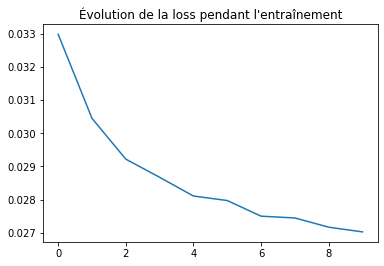

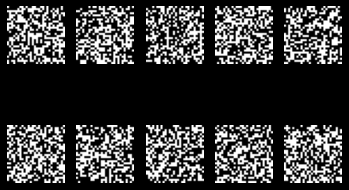

In [169]:
# Valeurs des hyper paramètres et entrainement
p = 784  # (égal à 28 * 28, la taille de l'image)
q = 128
rbm = RBM(p, q) # la taille du réseau est donc 784 * 128 = 100 352

epochs = 10
learning_rate = 0.01
batch_size = 100

RBM_trained, loss = rbm.train_RBM(X_train, epochs, learning_rate, batch_size)

plt.plot(loss)
plt.title("Évolution de la loss pendant l'entraînement")
plt.show()

n_iter = 1000
n_imgs = 10
RBM_trained.generer_image_RBM(n_imgs, n_iter, dataset='mnist')

Epoch 1 out of 100, loss: 0.01825636287511599
Epoch 20 out of 100, loss: 0.008553759387578092
Epoch 40 out of 100, loss: 0.007807746208001531
Epoch 60 out of 100, loss: 0.007594098607762749
Epoch 80 out of 100, loss: 0.007437081460741681
Epoch 100 out of 100, loss: 0.007322773877689147


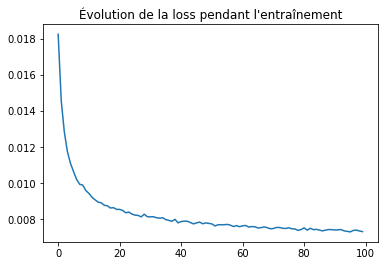

ValueError: cannot reshape array of size 784 into shape (20,16)

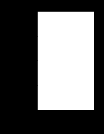

In [53]:
# Valeurs des hyper paramètres et entrainement
p = 784  # (égal à 28 * 28, la taille de l'image)
q = 600
rbm = RBM(p, q) # la taille du réseau est donc 784 * 600 = 470 400

epochs = 100
learning_rate = 0.01
batch_size = 32

RBM_trained, loss = rbm.train_RBM(X_train, epochs, learning_rate, batch_size)

plt.plot(loss)
plt.title("Évolution de la loss pendant l'entraînement")
plt.show()

n_iter = 1000
n_imgs = 10
RBM_trained.generer_image_RBM(n_imgs, n_iter, dataset='mnist')

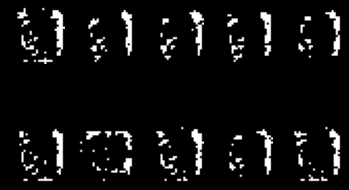

In [62]:
RBM_trained.generer_image_RBM(10, n_iter, dataset='mnist')

## DBN

In [127]:
784 * 400

313600

Epoch 1 out of 100, loss: 0.028911944026107292
Epoch 20 out of 100, loss: 0.01150595120667777
Epoch 40 out of 100, loss: 0.00980028046518538
Epoch 60 out of 100, loss: 0.008958235595504821
Epoch 80 out of 100, loss: 0.008397633052611186
Epoch 100 out of 100, loss: 0.008001860003754994
Epoch 1 out of 100, loss: 0.07775121578445368
Epoch 20 out of 100, loss: 0.03833868537877844
Epoch 40 out of 100, loss: 0.035748712257668486
Epoch 60 out of 100, loss: 0.03488045339418498
Epoch 80 out of 100, loss: 0.03443786586216037
Epoch 100 out of 100, loss: 0.034124851113424955
Epoch 1 out of 100, loss: 0.08889473019207386
Epoch 20 out of 100, loss: 0.05609484164471694
Epoch 40 out of 100, loss: 0.05336106036727556
Epoch 60 out of 100, loss: 0.05225250255940687
Epoch 80 out of 100, loss: 0.051424344575555975
Epoch 100 out of 100, loss: 0.05081433415292731


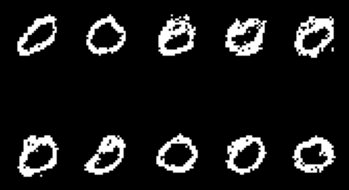

In [56]:
neurons = [X_train[0].shape[0], 400, 300, 100] 
# taille du réseau: 784 * 400 + 400 * 300 + 300 * 100 = 463 600
dbn = DBN(neurons)
dbn, losses = dbn.pretrain_DBN(X_train, n_epoch=100, lr_rate=0.001)
n_iter = 1000
n_imgs = 10
generated = dbn.generer_image_DBN(n_imgs, n_iter=n_iter, dataset='mnist')

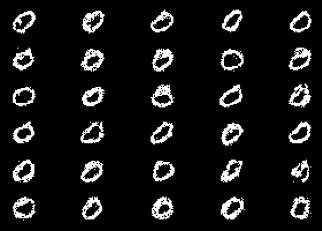

In [61]:
generated = dbn.generer_image_DBN(30, n_iter=n_iter, dataset='mnist')

As we can see here, our VAE seems to work better than our RBM. We can say the same for the DBN.